# Import

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows: 'Malgun Gothic', Mac: 'AppleGothic'
plt.rc('axes', unicode_minus=False)  # 마이너스 부호 깨짐 방지

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
from scipy.stats import mode

import xgboost as xgb

from imblearn.over_sampling import SMOTE

# Data load

In [44]:
# Train 데이터 로드
train = pd.read_csv('./data/train.csv')

# Test 데이터 로드
test = pd.read_csv('./data/test.csv')

# EDA (Exploratory Data Analysis)

In [6]:
# train 데이터 확인
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [7]:
# train 데이터 통곗값 확인
train.describe()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물여부
count,2.452000e+03,2452.000000,1665.000000,2223.000000,2436.000000,2436.000000,2434.000000,1756.000000,2452.000000,2452.000000
mean,1.574188e+08,380420.065253,27.009628,4.848403,8.052545,1.378079,1.034511,20.332574,5.477977,0.121533
std,1.212794e+08,206425.413601,7.951757,3.543348,4.920112,0.485007,0.182575,28.939900,5.631185,0.326813
min,5.000000e+06,0.000000,17.500000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,7.500000e+07,200000.000000,19.800000,2.000000,4.000000,1.000000,1.000000,4.000000,0.000000,0.000000
50%,1.325000e+08,380000.000000,26.400000,4.000000,6.000000,1.000000,1.000000,10.000000,5.000000,0.000000
75%,1.890000e+08,550000.000000,32.110000,6.000000,10.000000,2.000000,1.000000,31.000000,9.000000,0.000000
max,4.090000e+08,750000.000000,49.970000,21.000000,21.000000,2.000000,2.000000,590.000000,96.000000,1.000000


In [8]:
# train 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [9]:
print('train 데이터 총 개수: ', len(train))
print('test 데이터 총 개수: ', len(test))

train 데이터 총 개수:  2452
test 데이터 총 개수:  613


*데이터 수 매우 적음*

**컬럼:** 피처 15개, 타겟 1개

**숫자형 피처:** 보증금, 월세, 전용면적, 해당층, 총층, 방수, 욕실수, 총주차대수, 관리비

**문자형 피처:** ID, 매물확인방식, 방향, 주차가능여부, 중개사무소, 제공플랫폼, 게재일

**타겟:** 허위매물여부부

## 결측값 살펴보기

In [10]:
columns = train.columns # column들들 가져오기
print(columns)

Index(['ID', '매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
       '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부'],
      dtype='object')


In [11]:
# Train 데이터 결측치

for i in columns:
    print(i, '결측치: ', train[i].isnull().sum())

ID 결측치:  0
매물확인방식 결측치:  0
보증금 결측치:  0
월세 결측치:  0
전용면적 결측치:  787
해당층 결측치:  229
총층 결측치:  16
방향 결측치:  0
방수 결측치:  16
욕실수 결측치:  18
주차가능여부 결측치:  0
총주차대수 결측치:  696
관리비 결측치:  0
중개사무소 결측치:  0
제공플랫폼 결측치:  0
게재일 결측치:  0
허위매물여부 결측치:  0


In [12]:
# Test 데이터 결측치

for i in columns[:-1]:
    print(i, '결측치: ', test[i].isnull().sum())

ID 결측치:  0
매물확인방식 결측치:  0
보증금 결측치:  0
월세 결측치:  0
전용면적 결측치:  184
해당층 결측치:  50
총층 결측치:  2
방향 결측치:  0
방수 결측치:  2
욕실수 결측치:  2
주차가능여부 결측치:  0
총주차대수 결측치:  175
관리비 결측치:  0
중개사무소 결측치:  0
제공플랫폼 결측치:  0
게재일 결측치:  0


**결측치 있는 피처:** 전용면적, 해당층, 총층, 방수, 욕실수, 총주차대수

## 문자형 데이터들 unique한 값 확인

In [13]:
print('매물확인방식 unique 값: ', train['매물확인방식'].unique())
print()
print('방향 unique 값: ', train['방향'].unique())
print()
print('주차가능여부 unique 값: ', train['주차가능여부'].unique())
print()
#print('중개사무소 unique 값: ', train['중개사무소'].unique())
#print()
print('제공플랫폼 unique 값: ', train['제공플랫폼'].unique())
print()
#print('게재일 unique 값: ', train['게재일'].unique())


매물확인방식 unique 값:  ['현장확인' '전화확인' '서류확인']

방향 unique 값:  ['서향' '남동향' '동향' '남향' '북동향' '북향' '남서향' '북서향']

주차가능여부 unique 값:  ['가능' '불가능']

제공플랫폼 unique 값:  ['B플랫폼' 'D플랫폼' 'A플랫폼' 'C플랫폼' 'F플랫폼' 'G플랫폼' 'E플랫폼' 'J플랫폼' 'H플랫폼' 'I플랫폼'
 'L플랫폼' 'K플랫폼' 'M플랫폼']



In [14]:
print('중개사무소 unique 값: ', train['중개사무소'].unique())
print('게재일 unique 값: ', train['게재일'].unique())

중개사무소 unique 값:  ['t93Nt6I2I0' 'q39iV5J4E6' 'b03oE4G3F6' 'G52Iz8V2B9' 'N45gM0M7R0'
 'Q42YF3Y0I2' 'A72Mx9C8U2' 'd22DX4Y4P8' 'M90Ph8W9V3' 'J30yG7F1O0'
 'H90uE4C0W5' 'Y04yg0T7Z5' 'N00fb8Z9A4' 'G95MY2L8J8' 'r82ax9M3U3'
 'a15xR3G4V0' 'W88DA3W2Q3' 'S69fV9Z3J7' 'o80Xg3Q1Q7' 'K86UF7I0P3'
 'Q27Pd1N0R1' 'Z18up3D1C3' 'l47ci2X2G0' 'S30er7F3P4' 'D47oH9N4M3'
 'k74XT0T1B8' 'S12iP7V0Q9' 'S14na8Q8K2' 'C41wx1K6U9' 'm69GM9O9B3'
 'r16Dr6Z7C3' 'E29LO2X8S7' 'J07Zn4B0R7' 'b90Kl2S4L3' 't44kB9X5Y9'
 'w37Qk3B9D2' 'O55VW6U4R7' 'D49QC8I7L2' 'k87TR0Q8N4' 'o61te4S1W1'
 'K38kY2R6G0' 'Z81Jv8Z5G2' 'm44pw5A9I1' 'u04Gp5J3R0' 'K48zc2G4K8'
 'f41Wq8P7T9' 'o30ws9C6F7' 'J52gJ2E4T6' 'C10hv5Y7M9' 'z40LO7P9C9'
 'M02bn7Y4P0' 'Y65Hw0Z3K0' 'A18IU3D9M4' 'u92NN7A1E5' 'D26uW0Q2N3'
 'X71Iq5L2C6' 'I81Xq1F6S7' 'B44YF9W3O5' 'i07Ja2R7A8' 'b87Td0W4Y3'
 'z54Fl0B2P9' 's37cv8A6L4' 'K25cF2K7X6' 'U93ap2F8Z1' 'w14tG2G0E3'
 'M92wE9E7E5' 'y20fU5B1A8' 'X95Bu4S5H2' 'H58ZK7F1X4' 'O18HJ6L0R2'
 'c25Ms9V8I4' 'j90UQ8N6M3' 'K95Xf2B9C6' 'D24eh4J3C3' 'T86RB

In [15]:
print('중개사무소 unique 값 개수: ', len(train['중개사무소'].unique()))

중개사무소 unique 값 개수:  279


In [16]:
# 중개사무소 각각 값별로 개수 몇개인지 
a = train['중개사무소'].value_counts()

In [17]:
a.values

array([799,  43,  32,  30,  27,  25,  25,  24,  24,  23,  23,  23,  23,
        22,  20,  19,  19,  19,  19,  19,  18,  18,  18,  18,  18,  18,
        16,  16,  15,  15,  15,  14,  14,  14,  14,  14,  14,  14,  13,
        13,  13,  13,  13,  12,  12,  12,  12,  12,  11,  11,  11,  11,
        11,  11,  10,  10,  10,  10,   9,   9,   9,   9,   9,   9,   9,
         8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   7,   7,
         7,   7,   7,   7,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   

In [18]:
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 27, 30, 32, 43, 799]
len(b)

28

## 데이터 시각화

### 숫자형 데이터 시각화

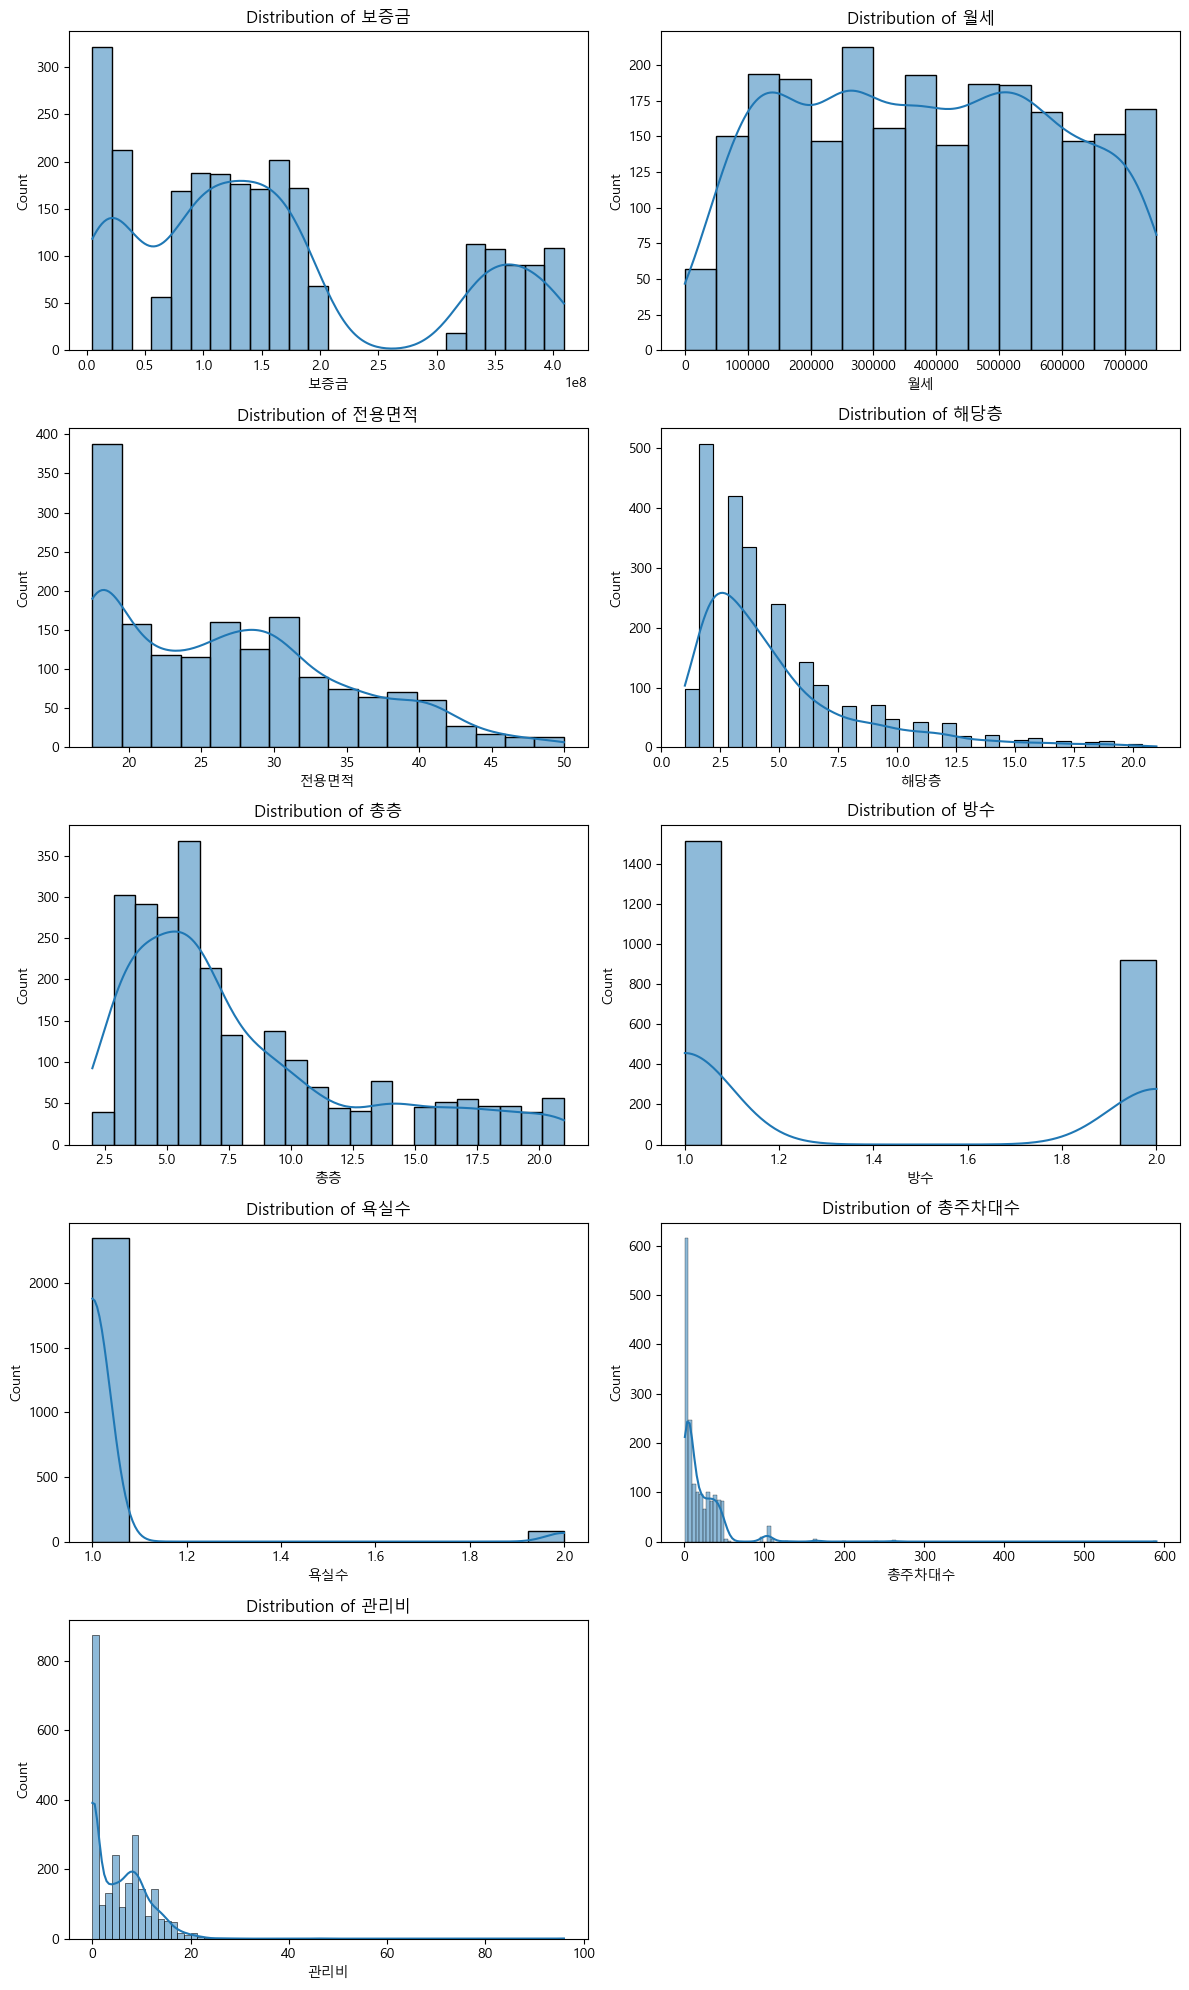

In [19]:
num_cols = ['보증금','월세','전용면적','해당층','총층','방수', '욕실수', '총주차대수', '관리비']

n_num = len(num_cols)
nrow_num = math.ceil(n_num / 2)

fig, axes = plt.subplots(nrow_num, 2, figsize=(12, 4 * nrow_num))
axes = axes.flatten()  # 2D -> 1D로 펼침

for i, col in enumerate(num_cols):
    sns.histplot(data=train, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# 사용되지 않은 서브플롯 숨김
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

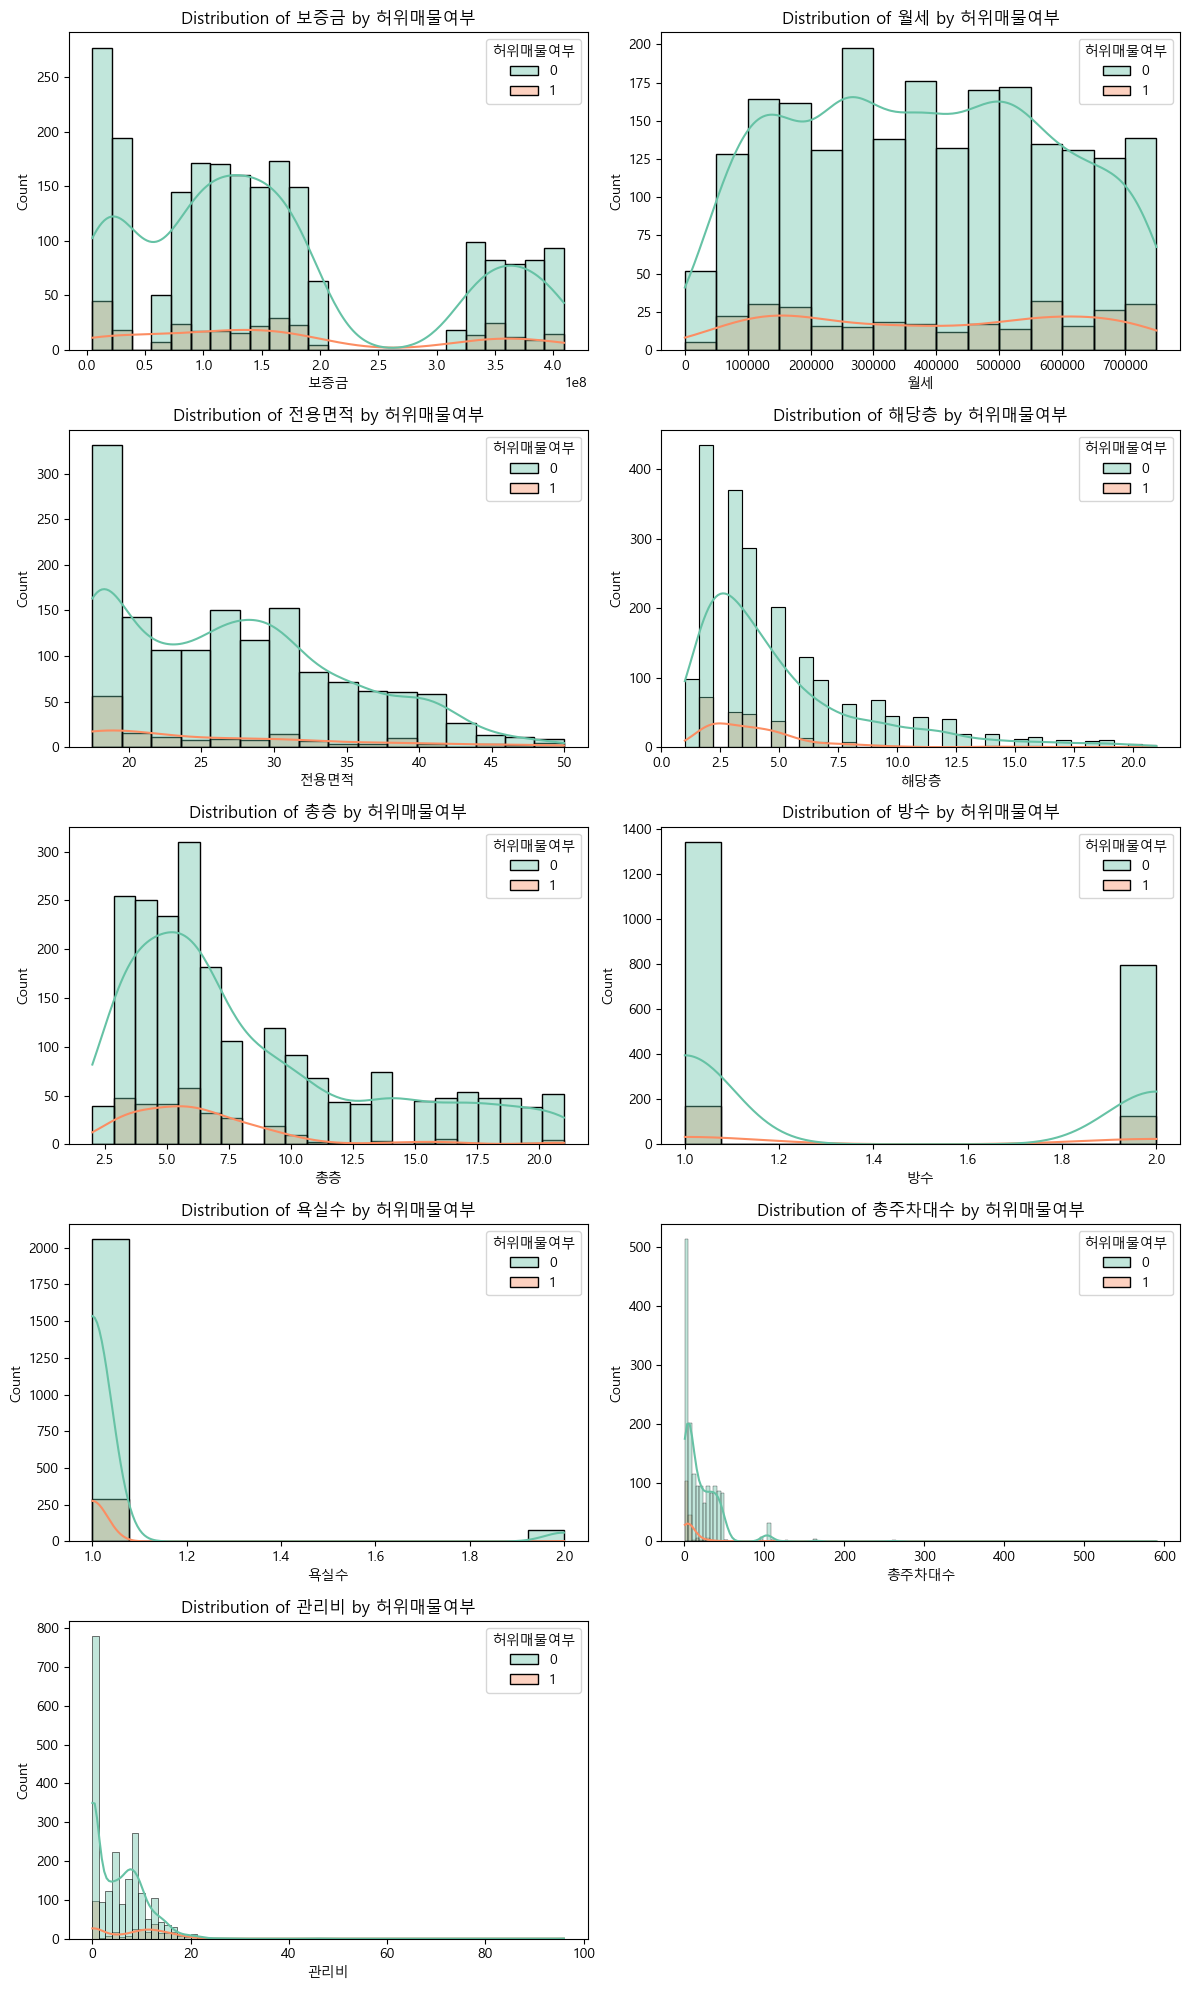

In [20]:
target = '허위매물여부'

n_num = len(num_cols)
nrow_num = math.ceil(n_num / 2)

fig, axes = plt.subplots(nrow_num, 2, figsize=(12, 4 * nrow_num))
axes = axes.flatten()  # 2D 배열을 1D로 펼침

for i, col in enumerate(num_cols):
    sns.histplot(data=train, x=col, hue=target, kde=True, ax=axes[i], palette='Set2', alpha=0.4)
    axes[i].set_title(f'Distribution of {col} by {target}')

# 사용하지 않는 서브플롯 숨기기
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### 문자형 데이터 시각화

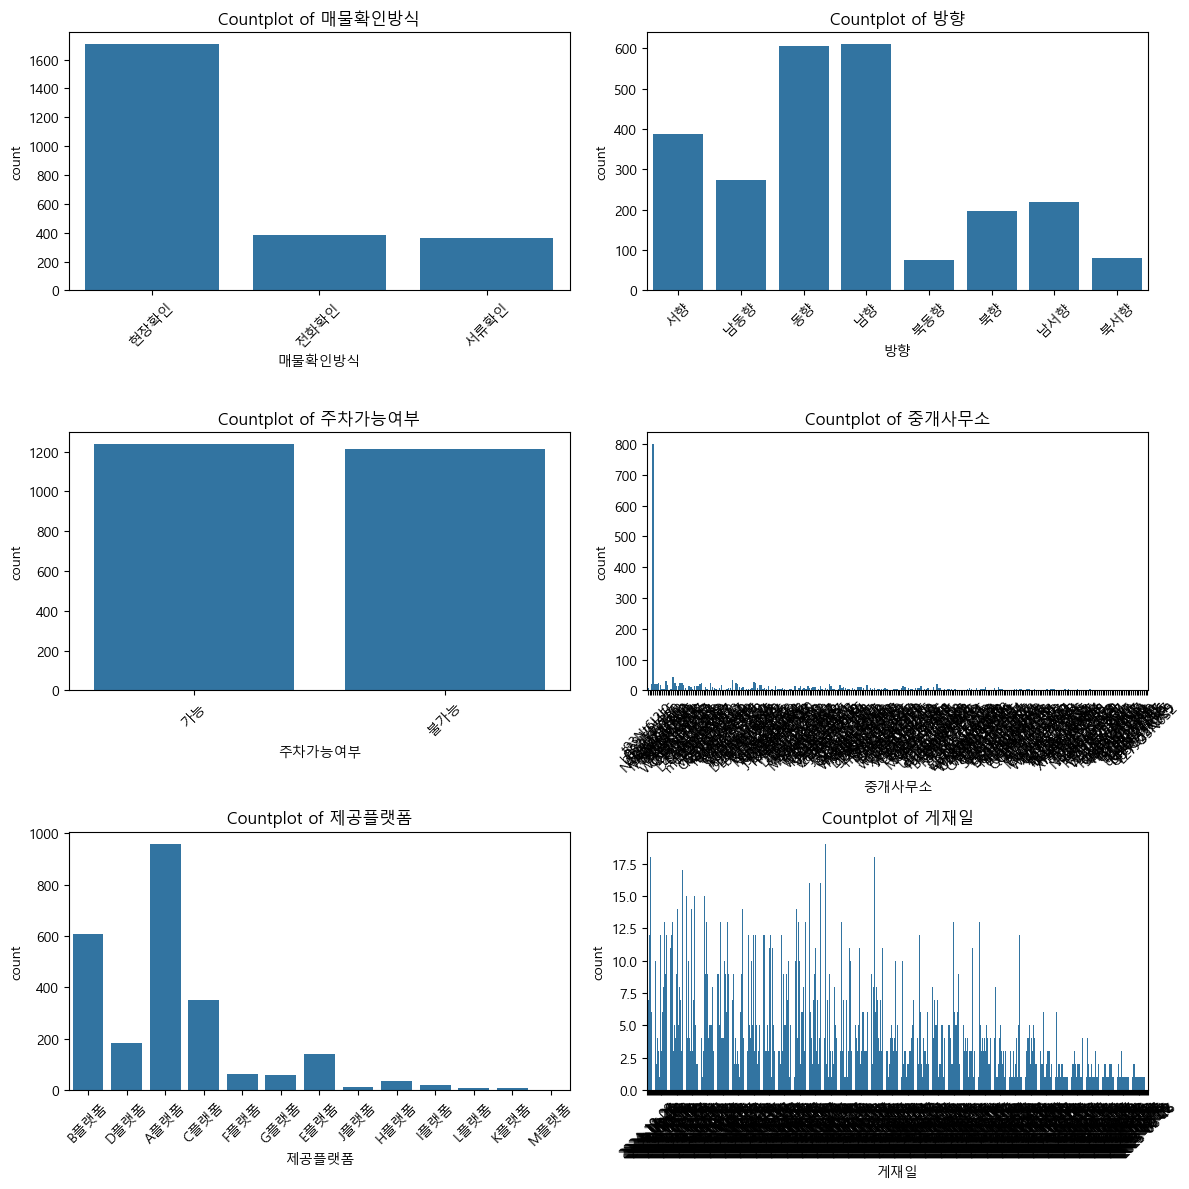

In [21]:
cat_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '게재일']

n_cat = len(cat_cols)
nrow_cat = math.ceil(n_cat / 2)

fig, axes = plt.subplots(nrow_cat, 2, figsize=(12, 4 * nrow_cat))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, ax=axes[i])
    axes[i].set_title(f'Countplot of {col}')
    axes[i].tick_params(axis='x', rotation=45)  # x축 라벨 겹침 방지

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

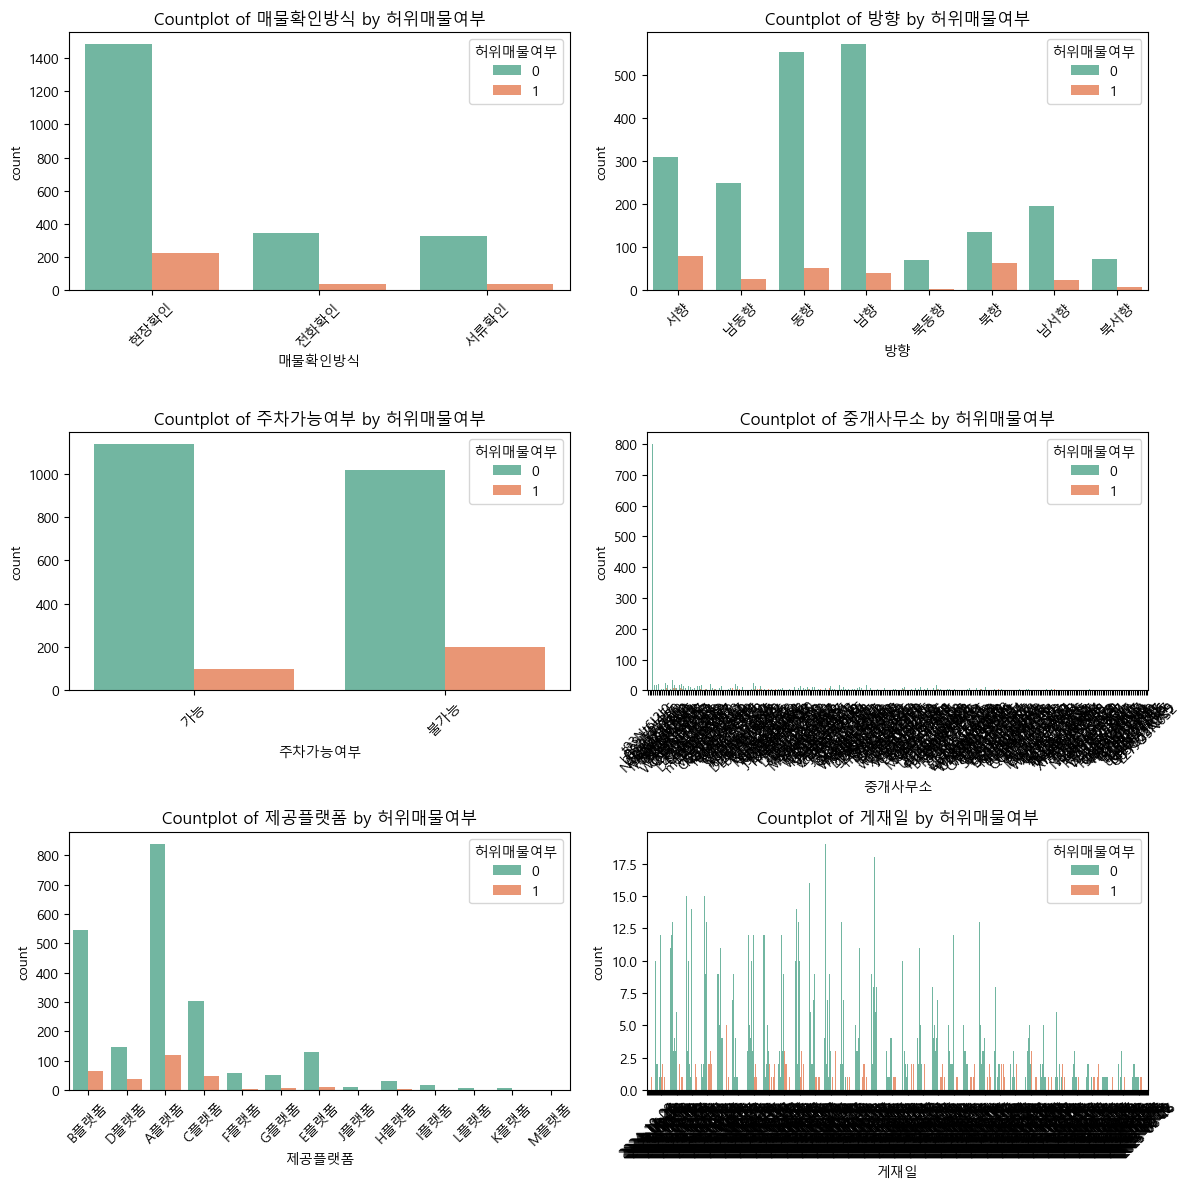

In [22]:
target = '허위매물여부'

n_cat = len(cat_cols)
nrow_cat = math.ceil(n_cat / 2)

fig, axes = plt.subplots(nrow_cat, 2, figsize=(12, 4 * nrow_cat))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, hue=target, ax=axes[i], palette='Set2', alpha=1)
    axes[i].set_title(f'Countplot of {col} by {target}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### 상관관계

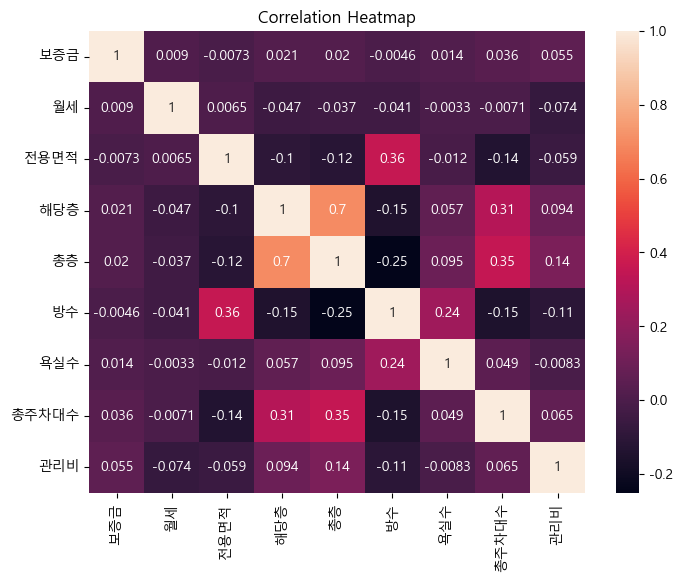

In [23]:
plt.figure(figsize=(8, 6))
corr_matrix = train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Pair Plot

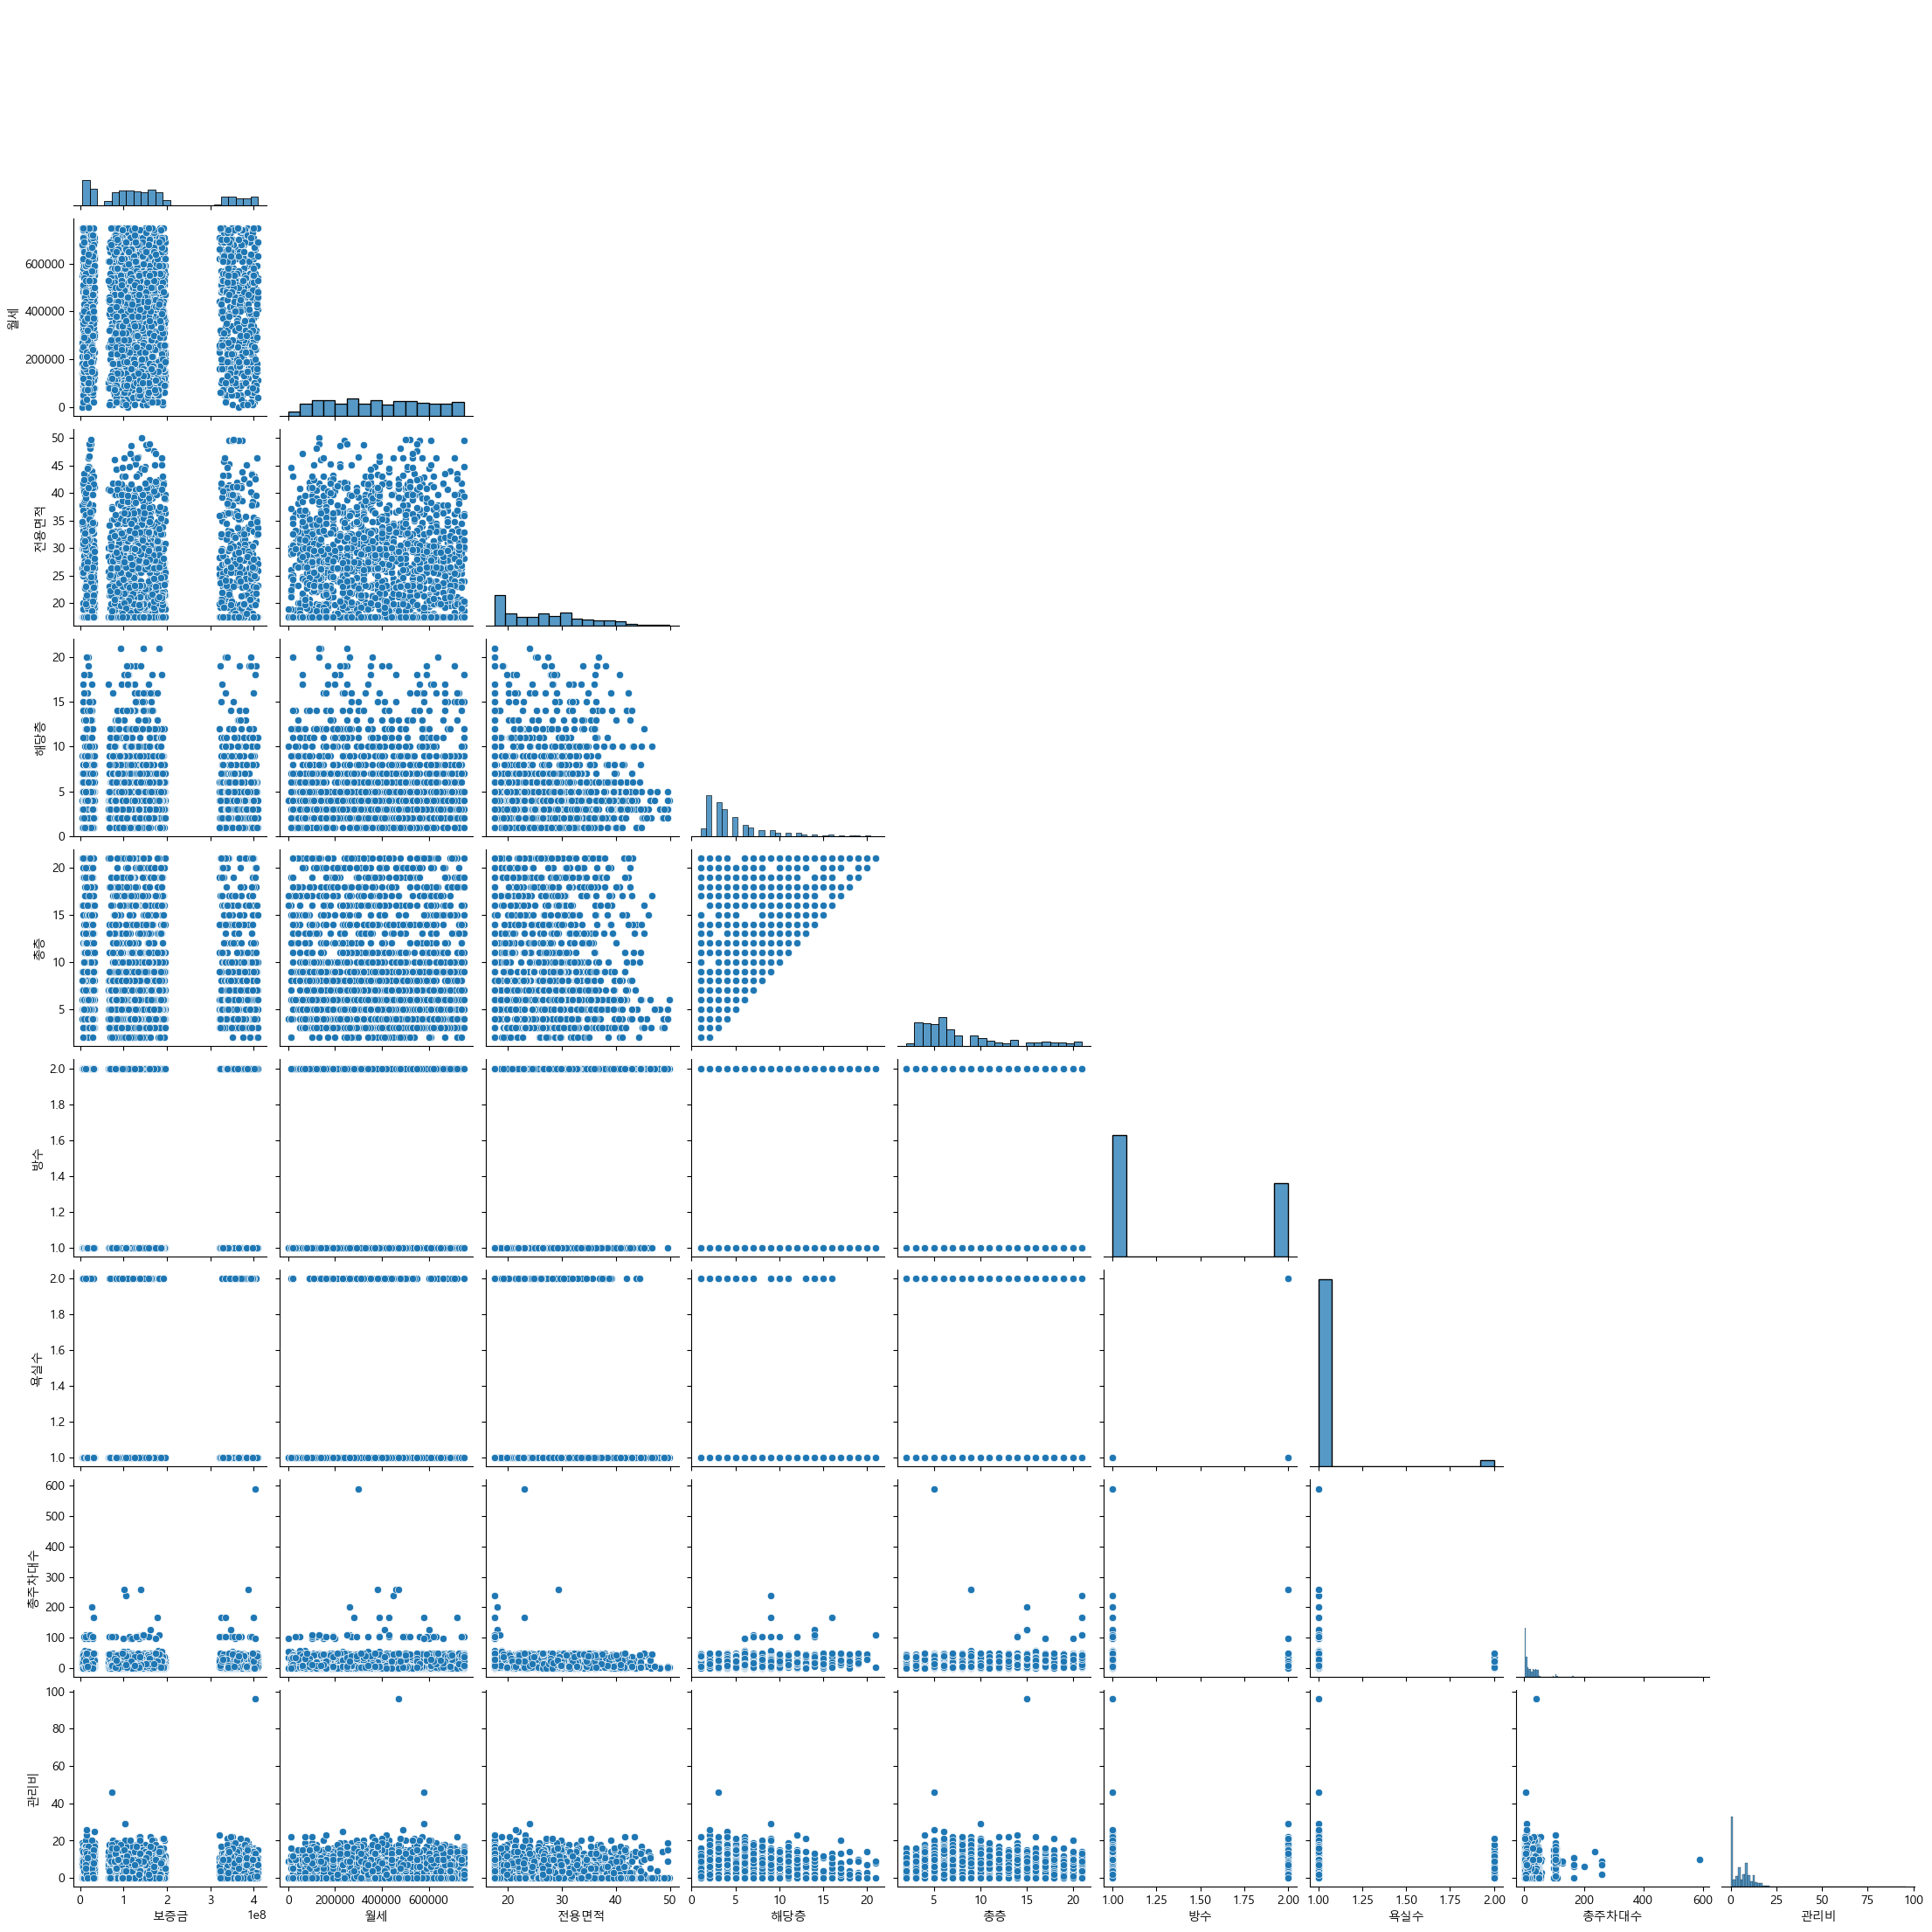

In [24]:
#여러 수치형 변수 간 분포(히스토그램)와 상관 관계(산점도)를 한 번에 보여줌.
sns.pairplot(train[num_cols], corner=True)
plt.show()

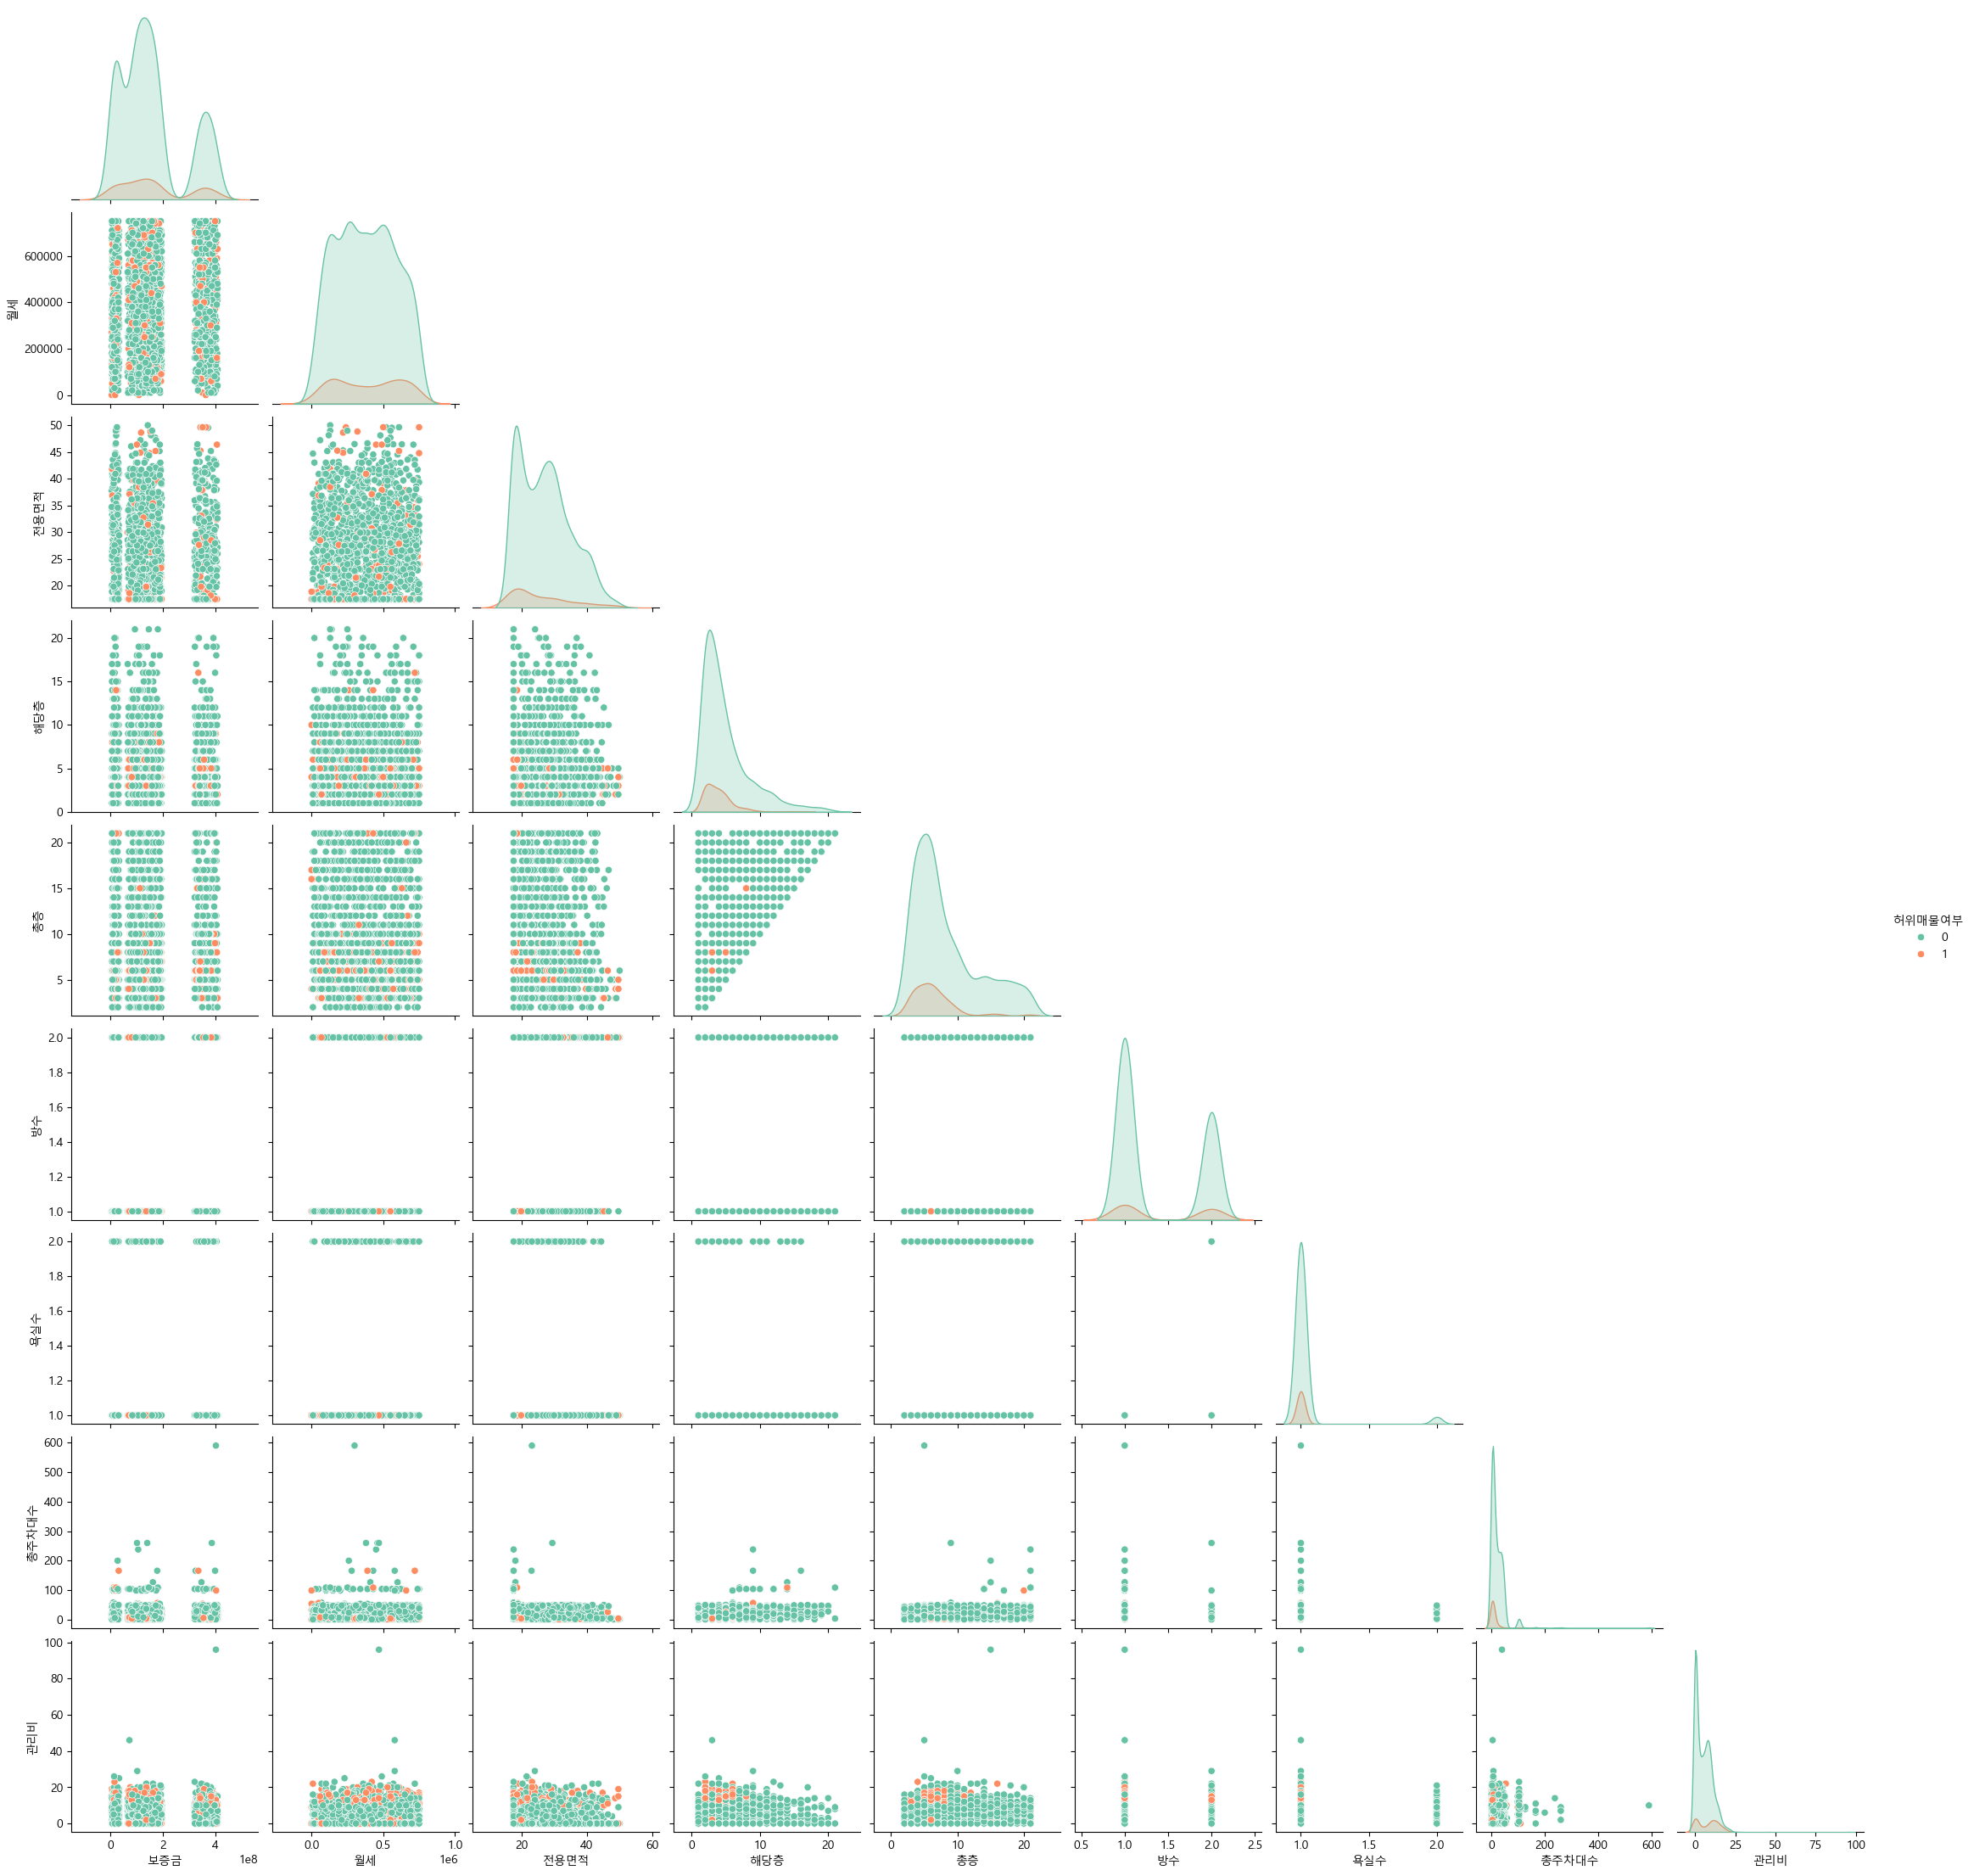

In [25]:
pair_data = train[num_cols + [target]]
sns.pairplot(pair_data, hue=target, corner=True, palette='Set2')
plt.show()

# 데이터 전처리

## Train

### drop

In [45]:
x = train.drop(['ID','허위매물여부'],axis=1)
y = train['허위매물여부']

### 문자형 데이터 처리

In [46]:
# Label Encoding 적용 열
#label_encode_cols = ['제공플랫폼','방향', '매물확인방식', '주차가능여부']
label_encode_cols = ['제공플랫폼','방향', '매물확인방식', '주차가능여부', '중개사무소']

label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))
    label_encoders[col] = le

### 중개사무소 처리

In [47]:
# 중개사무소별 거래 개수 계산 (훈련 데이터 기준)
transaction_counts = x['중개사무소'].value_counts().to_dict()  # 딕셔너리 형태로 변환

# 훈련 데이터 변환
x['중개사무소거래개수'] = x['중개사무소'].map(transaction_counts)
# x = x.drop(columns=['중개사무소'])  # 기존 컬럼 삭제


### 게재일 처리

In [48]:
# '게재일' 컬럼을 datetime 형식으로 변환
x['게재일'] = pd.to_datetime(x['게재일'])

# 연도(Year) 및 월(Month) 컬럼 생성
x['연도'] = x['게재일'].dt.year
x['월'] = x['게재일'].dt.month

# # 요일 (0: 월요일, 6: 일요일)
# x['요일'] = x['게재일'].dt.weekday  # 또는 .dt.weekday

# 월초(1~10), 월중순(11~20), 월말(21~31)로 카테고리 생성
x['월구간'] = pd.cut(
    x['게재일'].dt.day,
    bins=[0, 10, 20, 31],  # 구간: (0,10], (10,20], (20,31]
    labels=[0, 1, 2], #0: 월초, 1: 월중순, 2:월말
    right=True
).astype(int)  

x = x.drop(['게재일'],axis=1)

In [49]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   매물확인방식     2452 non-null   int32  
 1   보증금        2452 non-null   float64
 2   월세         2452 non-null   int64  
 3   전용면적       1665 non-null   float64
 4   해당층        2223 non-null   float64
 5   총층         2436 non-null   float64
 6   방향         2452 non-null   int32  
 7   방수         2436 non-null   float64
 8   욕실수        2434 non-null   float64
 9   주차가능여부     2452 non-null   int32  
 10  총주차대수      1756 non-null   float64
 11  관리비        2452 non-null   int64  
 12  중개사무소      2452 non-null   int32  
 13  제공플랫폼      2452 non-null   int32  
 14  중개사무소거래개수  2452 non-null   int64  
 15  연도         2452 non-null   int64  
 16  월          2452 non-null   int64  
 17  월구간        2452 non-null   int32  
dtypes: float64(7), int32(6), int64(5)
memory usage: 287.5 KB


In [50]:
x.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,중개사무소거래개수,연도,월,월구간
0,2,402500000.0,470000,NaN,NaN,15.0,7,1.0,1.0,0,40.0,96,240,1,6,2024,10,0
1,2,170500000.0,200000,NaN,3.0,4.0,0,2.0,1.0,1,NaN,0,228,3,2,2024,12,2
2,1,114000000.0,380000,NaN,2.0,3.0,3,1.0,1.0,1,NaN,0,150,0,19,2024,11,2
3,2,163500000.0,30000,36.3,3.0,9.0,0,2.0,1.0,0,13.0,10,31,0,799,2024,11,2
4,2,346000000.0,530000,NaN,3.0,3.0,3,2.0,1.0,1,NaN,0,72,1,19,2024,6,2


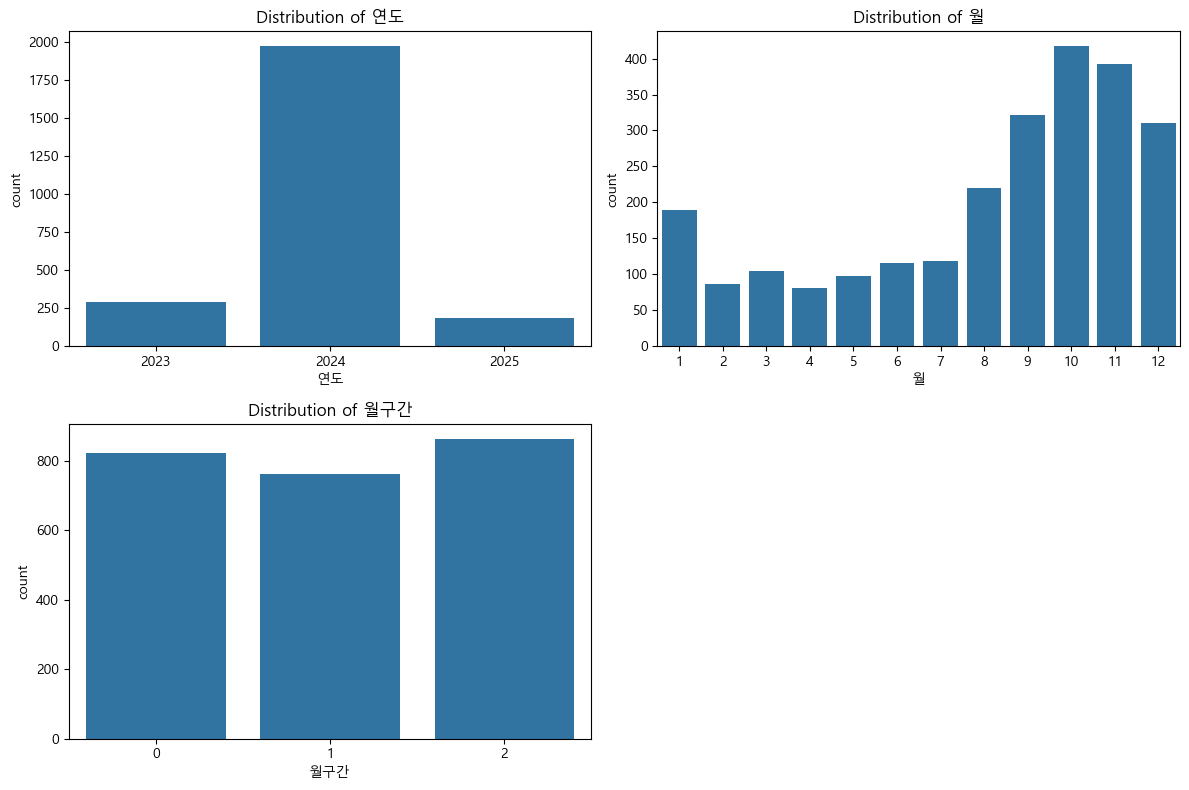

In [51]:
# 새로 만든 연도, 월, 월구간 그래프로 살펴보기

# num_cols = ['연도', '월', '월구간', '요일']
num_cols = ['연도', '월', '월구간']

n_num = len(num_cols)
nrow_num = math.ceil(n_num / 2)

fig, axes = plt.subplots(nrow_num, 2, figsize=(12, 4 * nrow_num))
axes = axes.flatten()  # 2D -> 1D로 펼침

for i, col in enumerate(num_cols):
    sns.countplot(data=x, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# 사용되지 않은 서브플롯 숨김
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

### 결측치 피처 생성

In [52]:
# 결측치 여부를 나타내는 새로운 피처 생성 (0: 결측치 없음, 1: 결측치 있음)

missing_features = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
#missing_features = ['전용면적', '해당층', '총주차대수']
# for col in missing_features:
#     x[f'{col}_결측여부'] = x[col].isna().astype(int)  # NaN이면 1, 아니면 0


# 하나라도 결측치가 있으면 1, 아니면 0
x["결측치_여부"] = x[missing_features].isna().any(axis=1).astype(int)

In [53]:
# missing_features = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']

# # SimpleImputer : 평균 대체
# mean_imputer = SimpleImputer(strategy='mean')


# # 학습 데이터에 fit 및 transform
# x[missing_features] = mean_imputer.fit_transform(x[missing_features])

## Test

### drop

In [54]:
test.drop(columns=['ID'] ,inplace=True)

### 문자형 데이터 처리

In [55]:
# Label Encoding
for col in label_encode_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)
        unseen = set(test[col].unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.append(le.classes_, list(unseen))
        test[col] = le.transform(test[col])

### 중개사무소 처리

In [56]:
# 테스트 데이터 변환
test['중개사무소거래개수'] = test['중개사무소'].map(transaction_counts)  # train 기준 매핑
test['중개사무소거래개수'] = test['중개사무소거래개수'].fillna(1)  # 없는 중개사무소는 1으로 처리
# test = test.drop(columns=['중개사무소'])  # 기존 컬럼 삭제

### 게재일 처리

In [57]:
# '게재일' 컬럼을 datetime 형식으로 변환
test['게재일'] = pd.to_datetime(test['게재일'])

# 연도(Year) 및 월(Month) 컬럼 생성
test['연도'] = test['게재일'].dt.year
test['월'] = test['게재일'].dt.month

# # 요일 (0: 월요일, 6: 일요일)
# test['요일'] = test['게재일'].dt.weekday  # 또는 .dt.weekday

# 월초(1~10), 월중순(11~20), 월말(21~31)로 카테고리 생성
test['월구간'] = pd.cut(
    test['게재일'].dt.day,
    bins=[0, 10, 20, 31],  # 구간: (0,10], (10,20], (20,31]
    labels=[0, 1, 2], #0: 월초, 1: 월중순, 2:월말
    right=True
).astype(int)  

test = test.drop(['게재일'],axis=1)

### 결측치 피처 생성

In [58]:
# 결측치 여부를 나타내는 새로운 피처 생성 (0: 결측치 없음, 1: 결측치 있음)

missing_features = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
#missing_features = ['전용면적', '해당층', '총주차대수']

# for col in missing_features:
#     test[f'{col}_결측여부'] = test[col].isna().astype(int)  # NaN이면 1, 아니면 0

# 하나라도 결측치가 있으면 1, 아니면 0
test["결측치_여부"] = x[missing_features].isna().any(axis=1).astype(int)

In [59]:
# # Test 결측값 대체
# missing_features = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
# test[missing_features] = mean_imputer.transform(test[missing_features])

## 추가

### 결측치 예측

In [60]:
def impute_missing_values_kfold_xgb(train_df, test_df, missing_columns, k=5, model=None):

    results = {}  # 성능 저장용

    train_filled = train_df.copy()  # 원본 데이터 변경 방지
    test_filled = test_df.copy()
    
    for column in missing_columns:
        print(f"ㅡㅡㅡㅡ {column} 결측치 대치중 ㅡㅡㅡㅡ")
        # print(train_filled.isna().sum())
        # print(test_filled.isna().sum())

        # 예측에 사용할 피처 선택 (결측치가 있는 컬럼 제외)
        X_train = train_filled.drop(columns=missing_columns) 
        y_train = train_filled[column]

        X_test = test_filled.drop(columns=missing_columns)
        y_test = test_filled[column]


        # 결측값이 없는 데이터만 학습에 사용
        X_train_train = X_train[~y_train.isna()]
        y_train_train = y_train[~y_train.isna()]

        # 결측값이 있는 데이터만 예측에 사용 (train & test)
        X_train_missing = X_train[y_train.isna()]
        X_test_missing = X_test[y_test.isna()]

        #######################################################
        # K-Fold 설정
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        # K-Fold 앙상블 예측을 저장할 리스트
        fold_predictions_train = []
        fold_predictions_test = []
        scores = []

        # K-Fold 교차 검증 수행
        for train_idx, val_idx in tqdm(kf.split(X_train_train), total=k, desc=f"{column} - Processing folds"):
            X_t, X_val = X_train_train.iloc[train_idx], X_train_train.iloc[val_idx]
            y_t, y_val = y_train_train.iloc[train_idx], y_train_train.iloc[val_idx]


            # 모델 학습
            model.fit(X_t, y_t)

            # 검증 데이터 예측 및 평가
            val_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            mae = mean_absolute_error(y_val, val_pred)
            scores.append((rmse, mae))

            # Train 결측값 예측 저장
            fold_predictions_train.append(model.predict(X_train_missing))

            # Test 결측값 예측 저장
            fold_predictions_test.append(model.predict(X_test_missing))

        # K-Fold 모든 예측의 평균을 사용하여 결측값 채우기
        final_predictions_train = np.mean(fold_predictions_train, axis=0)
        final_predictions_test = np.mean(fold_predictions_test, axis=0)
        
        train_filled.loc[train_filled[column].isnull(), column] = final_predictions_train
        test_filled.loc[test_filled[column].isnull(), column] = final_predictions_test
        

        # 결과 저장
        mean_rmse = np.mean([s[0] for s in scores])
        mean_mae = np.mean([s[1] for s in scores])

        results[column] = {
            'rmse': mean_rmse,
            'mae': mean_mae,
            'model': "XGBoost with K-Fold Bagging"
        }

    print(f"ㅡㅡㅡㅡ 결측치 대치 완료 ㅡㅡㅡㅡ")
    # print(train_filled.isna().sum())

    # 모델별 결과 요약을 DataFrame으로 변환
    result_df = pd.DataFrame.from_dict(results, orient='index')[['rmse', 'mae']]

    return train_filled,  test_filled, result_df

In [61]:
# 함수 실행 (K-Fold 배깅을 활용하여 결측치 예측 후 채우기)
missing_features = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']


# XGBoost 모델 정의
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

x_train_filled, x_test_filled, result_df = impute_missing_values_kfold_xgb(x, test, missing_features, k=10, model=xgb_regressor)

ㅡㅡㅡㅡ 전용면적 결측치 대치중 ㅡㅡㅡㅡ


전용면적 - Processing folds: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


ㅡㅡㅡㅡ 해당층 결측치 대치중 ㅡㅡㅡㅡ


해당층 - Processing folds: 100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


ㅡㅡㅡㅡ 총층 결측치 대치중 ㅡㅡㅡㅡ


총층 - Processing folds: 100%|██████████| 10/10 [00:01<00:00,  9.98it/s]


ㅡㅡㅡㅡ 방수 결측치 대치중 ㅡㅡㅡㅡ


방수 - Processing folds: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


ㅡㅡㅡㅡ 욕실수 결측치 대치중 ㅡㅡㅡㅡ


욕실수 - Processing folds: 100%|██████████| 10/10 [00:00<00:00, 10.54it/s]


ㅡㅡㅡㅡ 총주차대수 결측치 대치중 ㅡㅡㅡㅡ


총주차대수 - Processing folds: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]

ㅡㅡㅡㅡ 결측치 대치 완료 ㅡㅡㅡㅡ


In [62]:
result_df.head()

,rmse,mae
전용면적,7.935029,6.419004
해당층,3.382256,2.360656
총층,3.978358,2.856988
방수,0.470473,0.402748
욕실수,0.189329,0.070517


In [63]:
result_df.head()

,rmse,mae
전용면적,7.935029,6.419004
해당층,3.382256,2.360656
총층,3.978358,2.856988
방수,0.470473,0.402748
욕실수,0.189329,0.070517


### 상관관계 높은 피처 조절

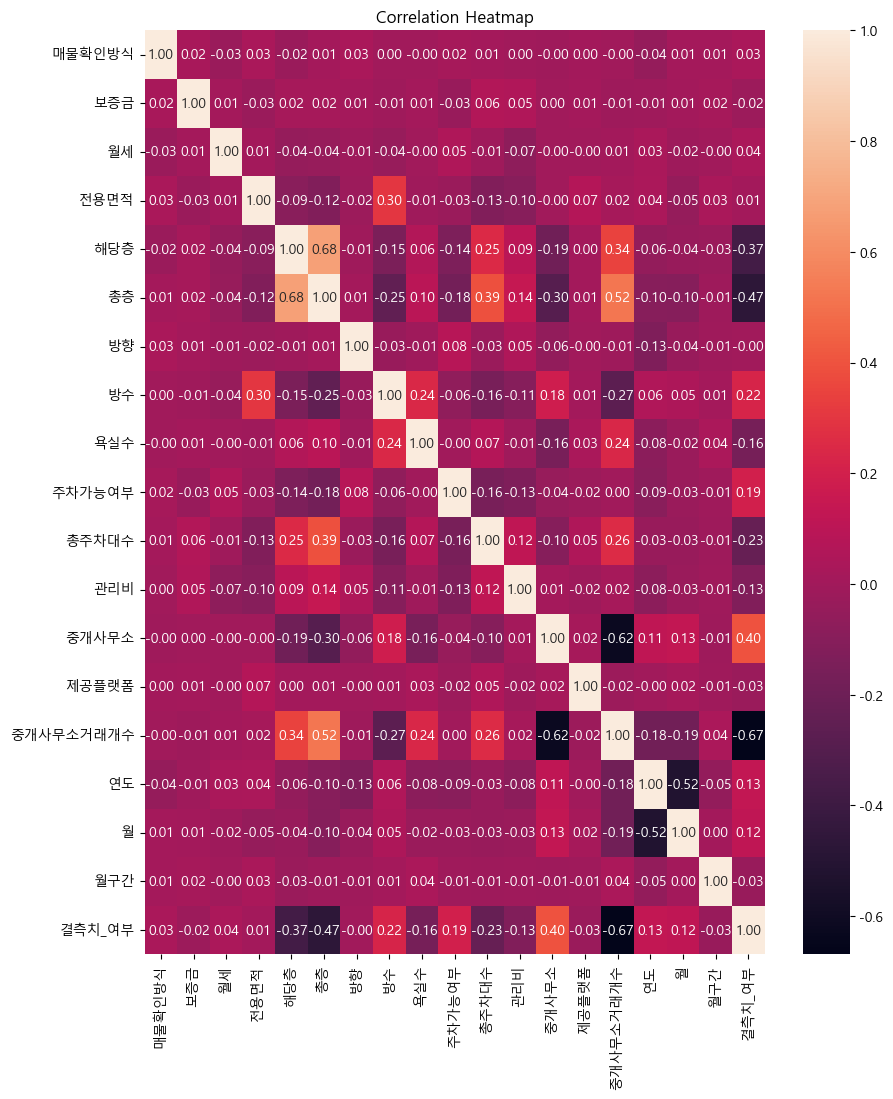

In [23]:
plt.figure(figsize=(10, 12))
corr_matrix = x_train_filled.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [24]:
# x_train_filled['층비율'] = x_train_filled['해당층'] / x_train_filled['총층']
# x_test_filled['층비율'] = x_test_filled['해당층'] / x_test_filled['총층']

# x_train_filled = x_train_filled.drop(['해당층','총층'],axis=1)
# x_test_filled = x_test_filled.drop(['해당층','총층'],axis=1)

### 데이터 분포 조정

In [64]:
# 변환할 컬럼 리스트
transform_cols = ['전용면적', '해당층', '총층', '총주차대수', '관리비']
#transform_cols = ['전용면적', '총주차대수', '관리비']


for col in transform_cols:
    x_train_filled[col] = np.log1p(np.maximum(x_train_filled[col], 0))  # 음수 값 방지
    x_test_filled[col] = np.log1p(np.maximum(x_test_filled[col], 0))  # 음수 값 방지

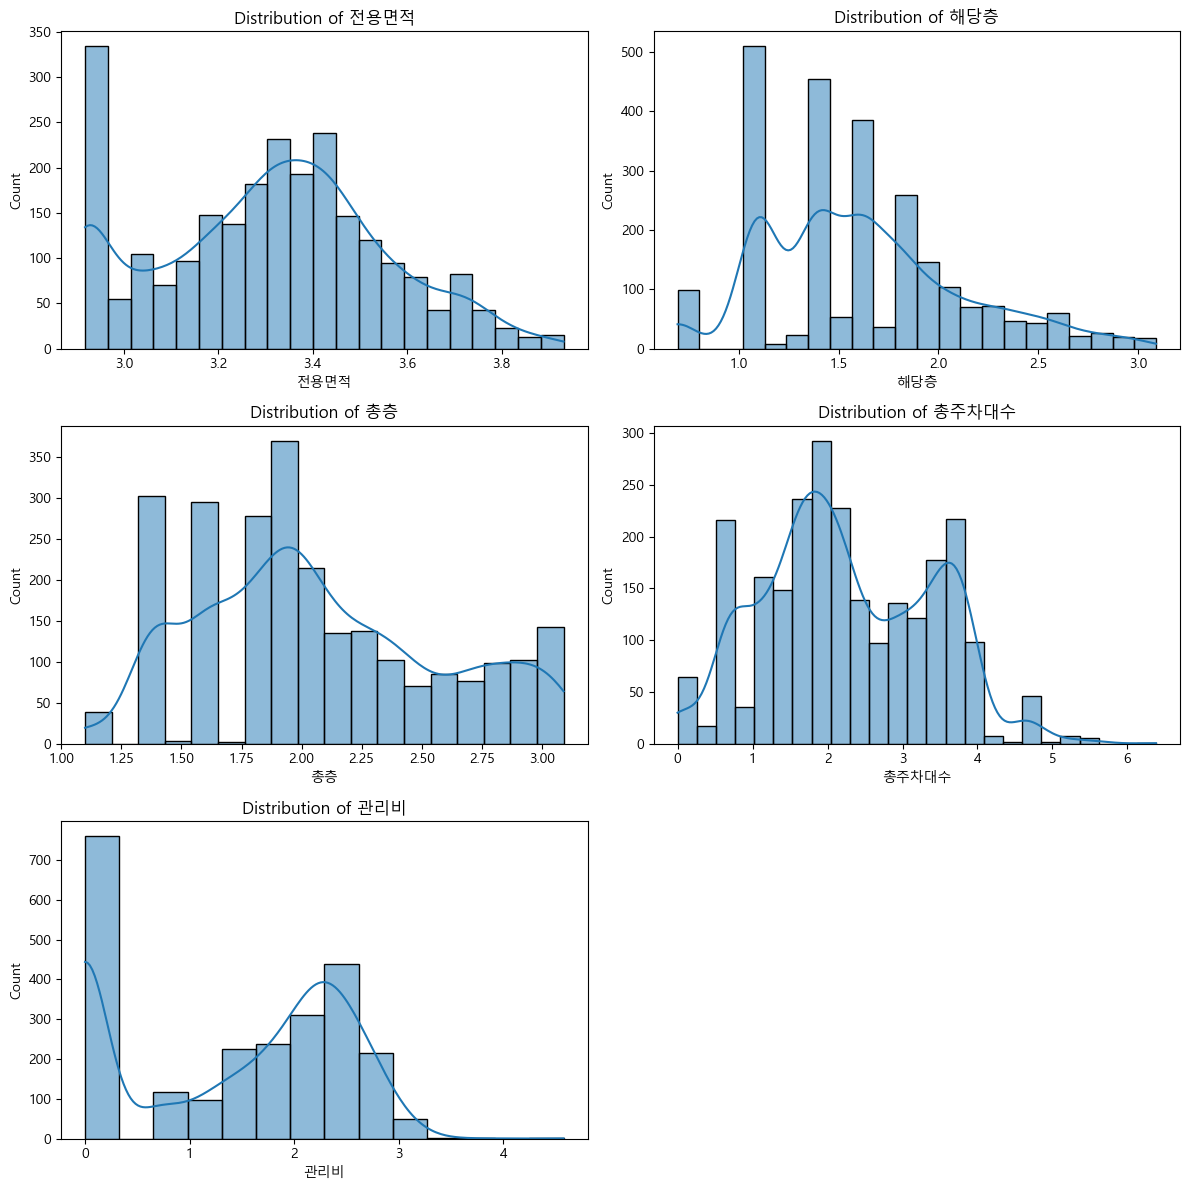

In [65]:
num_cols = ['전용면적', '해당층', '총층', '총주차대수', '관리비']

n_num = len(num_cols)
nrow_num = math.ceil(n_num / 2)

fig, axes = plt.subplots(nrow_num, 2, figsize=(12, 4 * nrow_num))
axes = axes.flatten()  # 2D -> 1D로 펼침

for i, col in enumerate(num_cols):
    sns.histplot(data=x_train_filled, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# 사용되지 않은 서브플롯 숨김
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

In [27]:
# num_cols = ['전용면적', '총주차대수', '관리비', '층비율']

# n_num = len(num_cols)
# nrow_num = math.ceil(n_num / 2)

# fig, axes = plt.subplots(nrow_num, 2, figsize=(12, 4 * nrow_num))
# axes = axes.flatten()  # 2D -> 1D로 펼침

# for i, col in enumerate(num_cols):
#     sns.histplot(data=x_train_filled, x=col, kde=True, ax=axes[i])
#     axes[i].set_title(f'Distribution of {col}')

# # 사용되지 않은 서브플롯 숨김
# for j in range(i + 1, len(axes)):
#     axes[j].set_visible(False)

# plt.tight_layout()

# 학습하기

## SMOTE 데이터 증강

In [67]:
# SMOTE 적용 (기본적으로 다수 클래스와 균형을 맞춤)
smote = SMOTE(random_state=42)
x_train_filled, y = smote.fit_resample(x_train_filled, y)

## 기본 모델

### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100,
                               criterion='gini',
                               max_depth=None,
                               random_state=42)
model.fit(x_train_filled, y)

RandomForestClassifier(random_state=42)

In [ ]:
final_prediction = model.predict(x_test_filled)

### xgboost

In [29]:
model = xgb.XGBClassifier() 
model.fit(x_train_filled, y)

final_prediction = model.predict(x_test_filled)

### optuna 하이퍼파라미터 튜닝

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

model = xgb.XGBClassifier() 

# 데이터 분할 (train : validation = 80:20)
X_train, X_valid, y_train, y_valid = train_test_split(
    x_train_filled, y, test_size=0.2, random_state=42, stratify=y
)


model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = model.predict(X_valid)

f1 = f1_score(y_valid, y_pred, average='macro')

print(f"F1-score (Macro): {f1:.4f}")

F1-score (Macro): 0.9698


In [37]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    # 탐색할 하이퍼파라미터 설정
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10.0),  # L1 정규화
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10.0),  # L2 정규화
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'  # XGBoost 경고 방지용
    }

    # 데이터 분할 (train : validation = 80:20)
    X_train, X_valid, y_train, y_valid = train_test_split(
        x_train_filled, y, test_size=0.2, random_state=42, stratify=y
    )

    # XGBoost 모델 학습
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)

    # 검증 데이터 예측
    y_pred = model.predict(X_valid)
    
    # F1-score (macro) 계산 → Optuna에서 최대화할 값
    return f1_score(y_valid, y_pred, average='macro')


In [38]:
# Optuna study 생성 (F1-score를 최대화하도록 설정)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)  # n_trials: 탐색 횟수 (조정 가능)

[I 2025-02-28 02:45:41,711] A new study created in memory with name: no-name-9c28826c-7e15-45e9-84d1-4709568f33f5
c:\Users\yebin\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-28 02:45:42,254] Trial 0 finished with value: 0.9535952884682677 and parameters: {'n_estimators': 381, 'learning_rate': 0.002275678482782977, 'max_depth': 5, 'subsample': 0.8584517263306521, 'colsample_bytree': 0.7332381836882763, 'gamma': 2.6903067382106745, 'reg_alpha': 6.3291047090460335, 'reg_lambda': 5.038227940953305}. Best is trial 0 with value: 0.9535952884682677.
c:\Users\yebin\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-28 02:45:42,849] Trial 1 finished with value: 0.9709976407825658 and parameters: {'n_estimators':

In [39]:
print("Best trial:")
best_trial = study.best_trial
print(f" Value (F1-score): {best_trial.value}")
print(" Params: ")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best trial:
 Value (F1-score): 0.9756380182573552
 Params: 
  n_estimators: 489
  learning_rate: 0.05949158396025925
  max_depth: 8
  subsample: 0.8264814830593752
  colsample_bytree: 0.9788980599059939
  gamma: 0.2800686917304737
  reg_alpha: 2.970630624244638
  reg_lambda: 4.705774960758827


In [35]:
print("Best trial:")
best_trial = study.best_trial
print(f" Value (F1-score): {best_trial.value}")
print(" Params: ")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best trial:
 Value (F1-score): 0.9756380182573552
 Params: 
  n_estimators: 200
  learning_rate: 0.039023005105467426
  max_depth: 6
  subsample: 0.9449226776276134
  colsample_bytree: 0.5486642299137726
  gamma: 0.16635482766193288
  reg_alpha: 1.0088448077348144
  reg_lambda: 0.38750180878318563


## K-fold 앙상블 모델

모델 성능 좋고 원하는거로 선택해서 쓰면 됨

1. xgboost
2. randomforest
3. lgbm (코드에는 없음. 원하면 본인이 넣으면 됨.)
4. 기타등등

In [68]:
## kfold 배깅 앙상블

# kfold 함수
def model_fitting(X_train, y_train, test, model, k):
    # k-Fold 설정
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # 각 fold의 모델로부터의 예측을 저장할 리스트와 f1 점수 리스트
    ensemble_predictions = []
    ensemble_predictions_train = []
    scores = []

    for train_idx, val_idx in tqdm(kf.split(X_train), total=k, desc="Processing folds"):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]
        
        # 각 모델 학습
        model.fit(X_t, y_t)
        
        # 각 모델로부터 Validation set에 대한 예측을 생성
        val_pred = model.predict(X_val)
        
        # Validation set에 대한 대회 평가 산식 계산 후 저장
        score = f1_score(y_val, val_pred, average='macro')
        scores.append(score)
        print(score)
        
        #train 데이터셋에 대해 앙상블 성능평가 (train 데이터셋에 대한 예측 수행 후 저장)
        model_pred_train = model.predict(X_train)
        ensemble_predictions_train.append(model_pred_train)    
        
        # test 데이터셋에 대한 예측 수행 후 저장
        model_pred = model.predict(test)        
        ensemble_predictions.append(model_pred)
        
    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 voting 앙상블 예측 생성
    # test 데이터 앙상블
    final_predictions, _ = mode(ensemble_predictions, axis=0)
    final_predictions = final_predictions.ravel()
    
    # train 데이터 앙상블(성능평가용)
    final_predictions_train, _ = mode(ensemble_predictions_train, axis=0)
    final_predictions_train = final_predictions_train.ravel()
    
    
    feature_importances = model.feature_importances_
    
    # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
    print("Validation : fl scores for each fold:", scores)
    print("Validation : fl socres mean:", np.mean(scores))
    print("emsemble : fl socres train:", f1_score(y_train, final_predictions_train, average='macro'))
    return final_predictions, feature_importances

### **xgboost**

Processing folds:  20%|██        | 2/10 [00:00<00:01,  7.41it/s]

0.9698213410463157
0.9698349888287706


Processing folds:  40%|████      | 4/10 [00:00<00:00,  7.56it/s]

0.9744757597781906
0.9766613238606827


Processing folds:  60%|██████    | 6/10 [00:00<00:00,  7.70it/s]

0.9767980189491817
0.9744757597781906


Processing folds:  80%|████████  | 8/10 [00:01<00:00,  7.47it/s]

0.969814187278105
0.9721240082787168


Processing folds: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]

0.974206424945059
0.9813695543857368



C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

Validation : fl scores for each fold: [0.9698213410463157, 0.9698349888287706, 0.9744757597781906, 0.9766613238606827, 0.9767980189491817, 0.9744757597781906, 0.969814187278105, 0.9721240082787168, 0.974206424945059, 0.9813695543857368]
Validation : fl socres mean: 0.9739581367128949
emsemble : fl socres train: 1.0


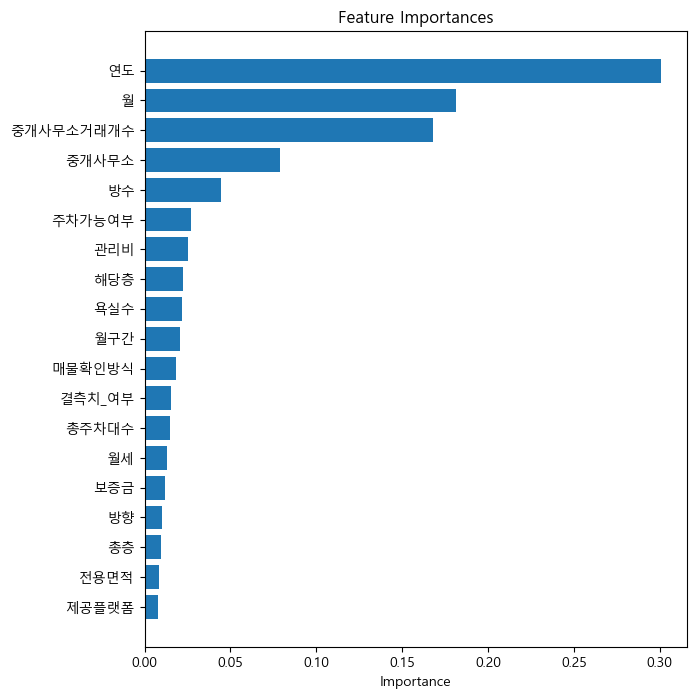

In [350]:
# 학습에 사용할 모델 Xgboost
xgboost = xgb.XGBClassifier() 

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction, feature_importances = model_fitting(x_train_filled, y, x_test_filled, xgboost, 10)



## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x.shape[1]), x.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

Processing folds:  20%|██        | 2/10 [00:00<00:01,  7.38it/s]

0.9721396250808015
0.9651942178793507


Processing folds:  40%|████      | 4/10 [00:00<00:00,  7.64it/s]

0.9791178798107205
0.9790025820490751


Processing folds:  60%|██████    | 6/10 [00:00<00:00,  7.67it/s]

0.9744774086575472
0.9721504264667873


Processing folds:  80%|████████  | 8/10 [00:01<00:00,  7.64it/s]

0.969814187278105
0.9767700068989307


Processing folds: 100%|██████████| 10/10 [00:01<00:00,  7.61it/s]

0.971849427168576
0.9837010965209152



C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

Validation : fl scores for each fold: [0.9721396250808015, 0.9651942178793507, 0.9791178798107205, 0.9790025820490751, 0.9744774086575472, 0.9721504264667873, 0.969814187278105, 0.9767700068989307, 0.971849427168576, 0.9837010965209152]
Validation : fl socres mean: 0.974421685781081
emsemble : fl socres train: 1.0


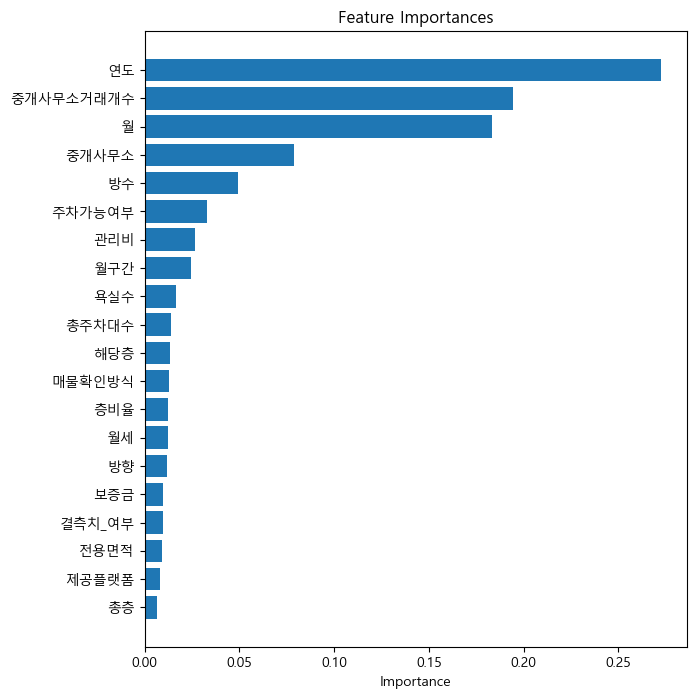

In [484]:
# 학습에 사용할 모델 Xgboost
xgboost = xgb.XGBClassifier() 

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction, feature_importances = model_fitting(x_train_filled, y, x_test_filled, xgboost, 10)



## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x_train_filled.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x_train_filled.shape[1]), x_train_filled.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

Processing folds:  20%|██        | 2/10 [00:00<00:01,  7.51it/s]

0.9791021296540726
0.9744757597781906


Processing folds:  40%|████      | 4/10 [00:00<00:00,  7.56it/s]

0.9744757597781906
0.9766613238606827


Processing folds:  60%|██████    | 6/10 [00:00<00:00,  7.65it/s]

0.9767970196821569
0.9651904697805895


Processing folds:  80%|████████  | 8/10 [00:01<00:00,  7.52it/s]

0.9767700068989307
0.9790895124120644


Processing folds: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]

0.976561137275423
0.9743685616590532



C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

Validation : fl scores for each fold: [0.9791021296540726, 0.9744757597781906, 0.9744757597781906, 0.9766613238606827, 0.9767970196821569, 0.9651904697805895, 0.9767700068989307, 0.9790895124120644, 0.976561137275423, 0.9743685616590532]
Validation : fl socres mean: 0.9753491680779355
emsemble : fl socres train: 1.0


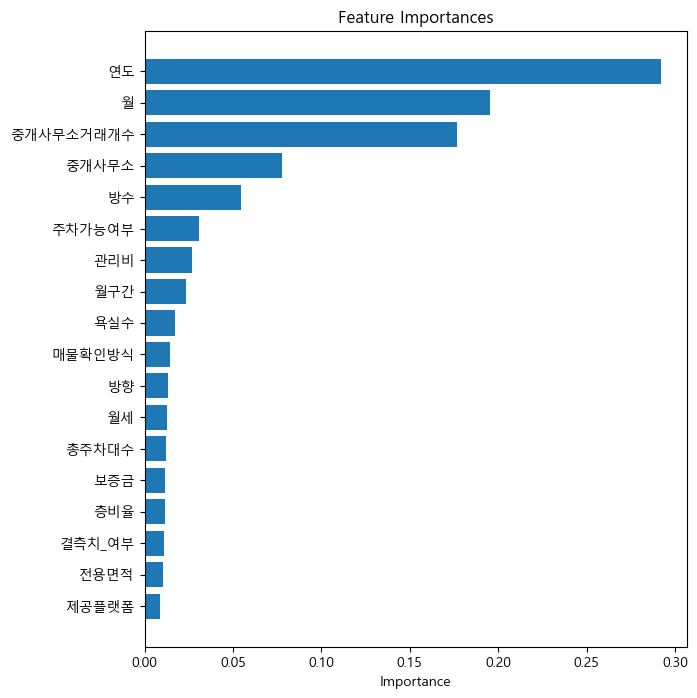

In [516]:
# 학습에 사용할 모델 Xgboost
xgboost = xgb.XGBClassifier() 

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction, feature_importances = model_fitting(x_train_filled, y, x_test_filled, xgboost, 10)



## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x_train_filled.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x_train_filled.shape[1]), x_train_filled.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

c:\Users\yebin\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Processing folds:  10%|█         | 1/10 [00:00<00:02,  3.16it/s]

0.9674878227509807


Processing folds:  20%|██        | 2/10 [00:00<00:02,  3.30it/s]

0.9651852210859626


Processing folds:  30%|███       | 3/10 [00:00<00:02,  3.35it/s]

0.9698349888287706


Processing folds:  40%|████      | 4/10 [00:01<00:01,  3.32it/s]

0.9789875680507027


Processing folds:  50%|█████     | 5/10 [00:01<00:01,  3.39it/s]

0.9675158275550196


Processing folds:  60%|██████    | 6/10 [00:01<00:01,  3.28it/s]

0.9675032313657905


Processing folds:  70%|███████   | 7/10 [00:02<00:00,  3.31it/s]

0.9674667874396135


Processing folds:  80%|████████  | 8/10 [00:02<00:00,  3.35it/s]

0.9698057284509471


Processing folds:  90%|█████████ | 9/10 [00:02<00:00,  3.33it/s]

0.9741839001413609


Processing folds: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

0.9720543315786053
Validation : fl scores for each fold: [0.9674878227509807, 0.9651852210859626, 0.9698349888287706, 0.9789875680507027, 0.9675158275550196, 0.9675032313657905, 0.9674667874396135, 0.9698057284509471, 0.9741839001413609, 0.9720543315786053]
Validation : fl socres mean: 0.9700025407247752
emsemble : fl socres train: 0.9907149469310076



C:\Users\yebin\AppData\Local\Temp\ipykernel_23892\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_23892\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

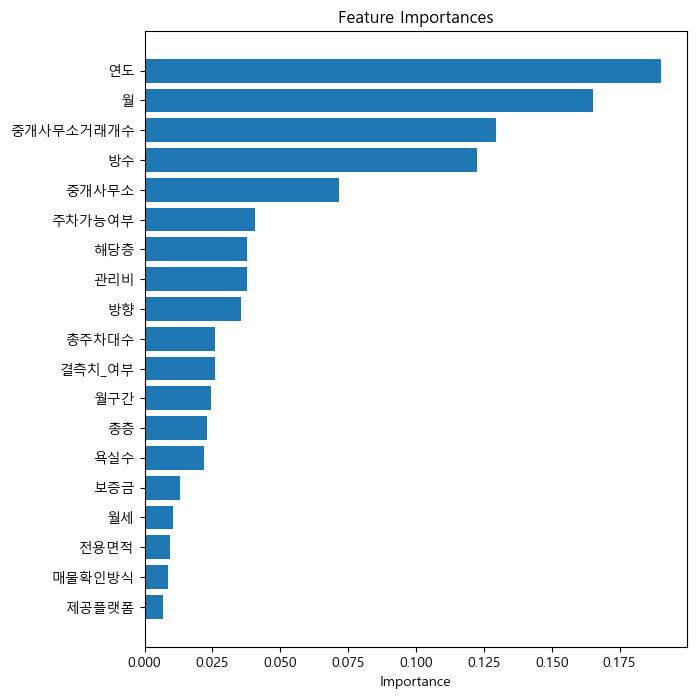

In [71]:
# 최적의 하이퍼파라미터 설정
best_params = {
    'n_estimators': 200,
    'learning_rate': 0.039023005105467426,
    'max_depth': 6,
    'subsample': 0.9449226776276134,
    'colsample_bytree': 0.5486642299137726,
    'gamma': 0.16635482766193288,
    'reg_alpha': 1.0088448077348144,
    'reg_lambda': 0.38750180878318563,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'  # 이진 분류이므로 logloss 사용
}

# 최적의 XGBoost 모델 생성
xgboost = xgb.XGBClassifier(**best_params)

# # 학습에 사용할 모델 Xgboost
# xgboost = xgb.XGBClassifier() 

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction, feature_importances = model_fitting(x_train_filled, y, x_test_filled, xgboost, 10)



## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x_train_filled.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x_train_filled.shape[1]), x_train_filled.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

c:\Users\yebin\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Processing folds:  10%|█         | 1/10 [00:00<00:03,  2.79it/s]

0.9674878227509807


Processing folds:  20%|██        | 2/10 [00:00<00:02,  2.96it/s]

0.9651852210859626


Processing folds:  30%|███       | 3/10 [00:01<00:02,  2.99it/s]

0.9698349888287706


Processing folds:  40%|████      | 4/10 [00:01<00:02,  2.97it/s]

0.9789875680507027


Processing folds:  50%|█████     | 5/10 [00:01<00:01,  3.00it/s]

0.9675158275550196


Processing folds:  60%|██████    | 6/10 [00:02<00:01,  3.02it/s]

0.9675032313657905


Processing folds:  70%|███████   | 7/10 [00:02<00:00,  3.02it/s]

0.9674667874396135


Processing folds:  80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

0.9698057284509471


Processing folds:  90%|█████████ | 9/10 [00:03<00:00,  3.00it/s]

0.9741839001413609


Processing folds: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

0.9720543315786053
Validation : fl scores for each fold: [0.9674878227509807, 0.9651852210859626, 0.9698349888287706, 0.9789875680507027, 0.9675158275550196, 0.9675032313657905, 0.9674667874396135, 0.9698057284509471, 0.9741839001413609, 0.9720543315786053]
Validation : fl socres mean: 0.9700025407247752
emsemble : fl socres train: 0.9907149469310076



C:\Users\yebin\AppData\Local\Temp\ipykernel_23892\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_23892\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

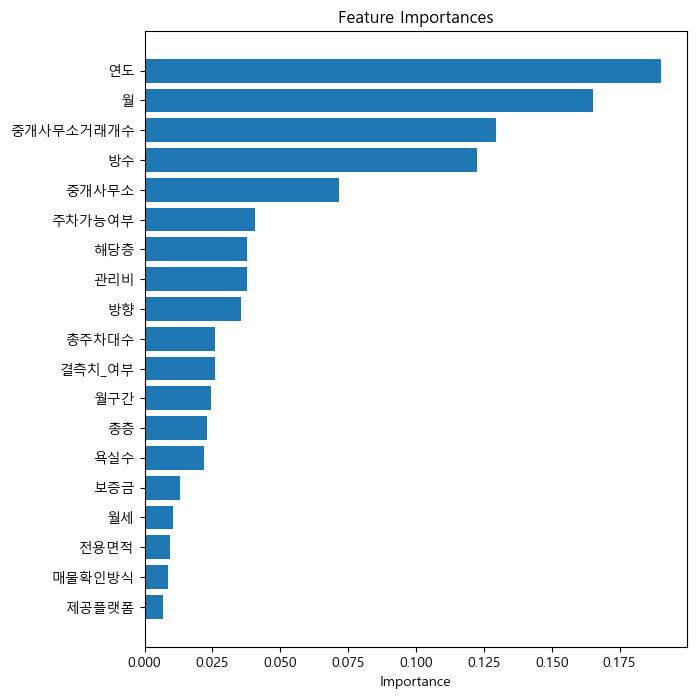

In [70]:
# 최적의 하이퍼파라미터 설정
best_params_updated = {
    'n_estimators': 489,
    'learning_rate': 0.05949158396025925,
    'max_depth': 8,
    'subsample': 0.8264814830593752,
    'colsample_bytree': 0.9788980599059939,
    'gamma': 0.2800686917304737,
    'reg_alpha': 2.970630624244638,
    'reg_lambda': 4.705774960758827,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'  # 이진 분류이므로 logloss 사용
}

# 최적의 XGBoost 모델 생성
xgboost = xgb.XGBClassifier(**best_params)

# # 학습에 사용할 모델 Xgboost
# xgboost = xgb.XGBClassifier() 

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction, feature_importances = model_fitting(x_train_filled, y, x_test_filled, xgboost, 10)



## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x_train_filled.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x_train_filled.shape[1]), x_train_filled.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

### **Random Forest**

Processing folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

0.9675172265288544


Processing folds:  40%|████      | 2/5 [00:00<00:01,  2.19it/s]

0.9686588931097774


Processing folds:  60%|██████    | 3/5 [00:01<00:00,  2.19it/s]

0.9593809533426231


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

0.965155619347737


Processing folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

0.9673156182212581
Validation : fl scores for each fold: [0.9675172265288544, 0.9686588931097774, 0.9593809533426231, 0.965155619347737, 0.9673156182212581]
Validation : fl socres mean: 0.9656056621100501
emsemble : fl socres train: 1.0



C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(ensemble_predictions, axis=0)
C:\Users\yebin\AppData\Local\Temp\ipykernel_24860\3165496035.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

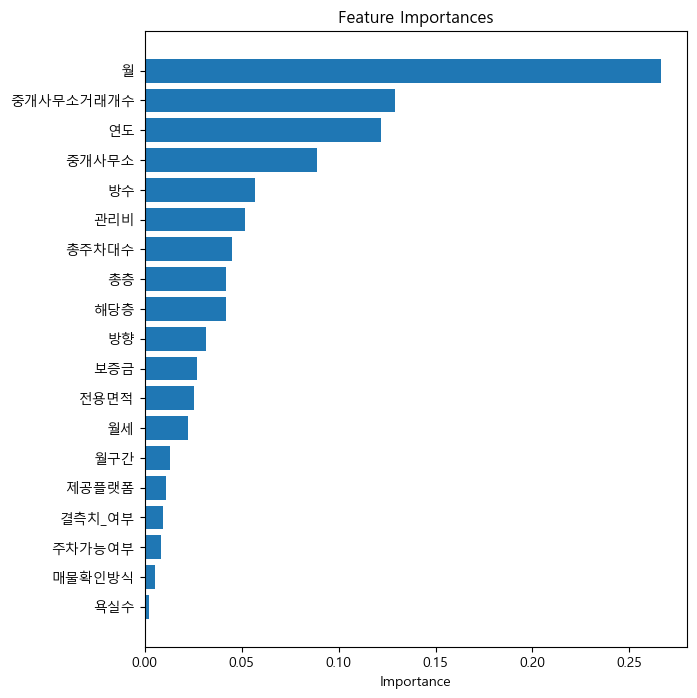

In [296]:
# 학습에 사용할 모델 Random Forest
randomforest = RandomForestClassifier(n_estimators=100,
                               criterion='gini',
                               max_depth=None,
                               random_state=42)

# 최종 test 예측 결과 와 feature importances 가져오기
final_prediction_randomforest, feature_importances = model_fitting(x_train_filled, y, x_test_filled, randomforest, 5)


## feature importances 시각화
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(7, 8))
plt.title(f"Feature Importances")
plt.barh(range(x.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x.shape[1]), x.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

# 제출하기

In [72]:
submit = pd.read_csv('./data/sample_submission.csv')

In [73]:
submit['허위매물여부'] = final_prediction
submit.head()

,ID,허위매물여부
0,TEST_000,0
1,TEST_001,0
2,TEST_002,1
3,TEST_003,0
4,TEST_004,0


In [74]:
# 제출 파일 이름, 경로 => 원하는대로 변경

submit.to_csv('./submission_predict_optuna.csv',index=False)